# 데이터 불러오기

In [6]:
import pandas as pd
df = pd.read_csv('전처리완료.csv', encoding='CP949', low_memory=False)
df = df.drop(['증정강조','예약구매'], axis=1)

df2 = df.copy()

df2['기저귀단계'] = df2['기저귀단계'].fillna('알수없음')
df2['남아여아공용'] = df2['남아여아공용'].fillna('알수없음')

df2 = df2.dropna()

df2['주문번호'] = df2['주문번호'].astype(str)
df2['고객번호'] = df2['고객번호'].astype(str)

df2['배송완료일'] = pd.to_datetime(df2['배송완료일'], format='%Y-%m-%d', errors='coerce')
df2['배송시작일'] = pd.to_datetime(df2['배송시작일'], format='%Y-%m-%d', errors='coerce')
df2['구매일'] = pd.to_datetime(df2['구매일'], format='%Y-%m-%d', errors='coerce')
df2['마지막구매일'] = pd.to_datetime(df2['마지막구매일'], format='%Y-%m-%d', errors='coerce')

df2 = df2[df2['결제금액'] >= 0].reset_index(drop=True)

df2['물품대분류'] = df2['물품대분류'].astype('category')
df2['성별'] = df2['성별'].astype('category')
df2['결혼유무'] = df2['결혼유무'].astype('category')
df2['거주지역'] = df2['거주지역'].astype('category')
df2['결제등록카드'] = df2['결제등록카드'].astype('category')
df2['유입경로'] = df2['유입경로'].astype('category')
df2['자녀여부'] = df2['자녀여부'].astype('category')
df2['기저귀단계'] = df2['기저귀단계'].astype('category')
df2['남아여아공용'] = df2['남아여아공용'].astype('category')
df2['브랜드'] = df2['브랜드'].astype('category')
df2['원플원'] = df2['원플원'].astype('category')
df2['핫딜'] = df2['핫딜'].astype('category')
df2['쿠폰적용가강조'] = df2['쿠폰적용가강조'].astype('category')
df2['무료배송강조'] = df2['무료배송강조'].astype('category')
df2['기저귀밴드/팬티'] = df2['기저귀밴드/팬티'].astype('category')
df2['아이정보건너뛰기'] = df2['아이정보건너뛰기'].astype('category')

df2['구매시월령_bin'] = df2['구매시월령_bin'].astype('category')
df2['고객등급'] = df2['고객등급'].astype('category')
df2['등급별혜택_상품쿠폰'] = df2['등급별혜택_상품쿠폰'].astype('category')
df2['등급별혜택_쇼핑지원금'] = df2['등급별혜택_쇼핑지원금'].astype('category')
df2['등급별혜택_무료배송쿠폰'] = df2['등급별혜택_무료배송쿠폰'].astype('category')
df2['이탈등급'] = df2['이탈등급'].astype('category')
df2['당일출고서비스유무'] = df2['당일출고서비스유무'].astype('category')
df2['배송시작일_year'] = df2['배송시작일_year'].astype('category')
df2['배송시작일_month'] = df2['배송시작일_month'].astype('category')
df2['배송시작일_day'] = df2['배송시작일_day'].astype('category')

In [7]:
import pandas as pd

# 0) 기준일 정의
snapshot_date = df2['배송완료일'].max() + pd.Timedelta(days=1)

# 1) RFM 집계
rfm = df2.groupby('고객번호').agg({
    '배송완료일': lambda x: (snapshot_date - x.max()).days,
    '주문번호':  'nunique',
    '결제금액':  'sum'
}).rename(columns={
    '배송완료일': 'Recency',
    '주문번호':  'Frequency',
    '결제금액':  'Monetary'
})

# 2) 스코어링
# Recency: 값이 작을수록 점수 높음
rfm['R_score'] = pd.qcut(
    rfm['Recency'],
    q=5,
    labels=[5,4,3,2,1],
    duplicates='drop'
).astype(int)

# Frequency: 동일값 문제를 피하기 위해 rank 이용
rfm['F_score'] = pd.qcut(
    rfm['Frequency'].rank(method='first'),
    q=5,
    labels=[1,2,3,4,5]
).astype(int)

# Monetary: 동일값 문제를 피하기 위해 rank 이용
rfm['M_score'] = pd.qcut(
    rfm['Monetary'].rank(method='first'),
    q=5,
    labels=[1,2,3,4,5]
).astype(int)

# 3) RFM 조합
rfm['RFM_Segment'] = (
    rfm['R_score'].astype(str)
  + rfm['F_score'].astype(str)
  + rfm['M_score'].astype(str)
)
rfm['RFM_Score'] = rfm[['R_score','F_score','M_score']].sum(axis=1)

# 결과 확인
print(rfm[['Recency','R_score','Frequency','F_score','Monetary','M_score','RFM_Segment','RFM_Score']].head())
print("\nR_score 분포:\n", rfm['R_score'].value_counts().sort_index())
print("\nF_score 분포:\n", rfm['F_score'].value_counts().sort_index())
print("\nM_score 분포:\n", rfm['M_score'].value_counts().sort_index())


                 Recency  R_score  Frequency  F_score  Monetary  M_score  \
고객번호                                                                       
201812310749735      173        4          2        3   54083.0        4   
201812310749771      456        1          1        1   95844.0        5   
201812310749774      378        2          2        3  116532.0        5   
201812310749780      559        1          1        1   19900.0        3   
201812310749783       31        5          4        5  170124.0        5   

                RFM_Segment  RFM_Score  
고객번호                                    
201812310749735         434         11  
201812310749771         115          7  
201812310749774         235         10  
201812310749780         113          5  
201812310749783         555         15  

R_score 분포:
 R_score
1    13841
2    13810
3    13758
4    14097
5    13952
Name: count, dtype: int64

F_score 분포:
 F_score
1    13892
2    13891
3    13892
4    13891
5    13892


1. **고객별 대표 세그먼트 예시**

   * `201812310749783` (RFM=5-5-5, Score=15):

     * **가장 최근에 구매**(Recency=31일), **구매횟수 상위 20%**, **지출금액 상위 20%**
     * 전형적인 **VIP 고객**으로, 로열티 프로그램·프리미엄 혜택 대상
   * `201812310749735` (RFM=4-3-4, Score=11):

     * 비교적 최근(173일) 재구매, 중간 이상의 빈도·지출
     * **충성 고객**군(“Loyal”)으로 분류해 업셀링·크로스셀링 전략
   * `201812310749774` (RFM=2-3-5, Score=10):

     * 최근 이탈 구간(378일)이나 **높은 지출**(상위 20%)
     * **휴면 전환 위험 고객** → 재활성화 캠페인 필요
   * `201812310749771` (RFM=1-1-5, Score=7):

     * 오랜 비구매(456일), **지출은 높음**
     * **휴면 VIP 후보** → “보고 싶었어요” 메시지 + 전용 혜택
   * `201812310749780` (RFM=1-1-3, Score=5):

     * **이탈 위험군**(오랜 기간 미구매·낮은 빈도·중간 지출)
     * 우선순위 낮은 재관여 타깃, 대규모 캠페인 대상

2. **점수 분포의 균등함**

   * 각 R/F/M 점수 구간(1\~5점)에 고객이 거의 동일한 수로 분포
   * **균질한 세분화**가 잘 이뤄져 있어, 모든 세그먼트에 유사한 규모의 마케팅 자원 배분 가능

3. **세그먼트 활용 포인트**

   * **최우수(VIP, 555)**: 유지·강화
   * **Loyal(4xx, x4x 등)**: 업셀링·신제품 제안
   * **휴면 전환 위험(2xx, x2x)**: 재관여·리텐션 캠페인
   * **이탈(1xx, xx1)**: 대규모 할인·맞춤 광고로 복귀 유도

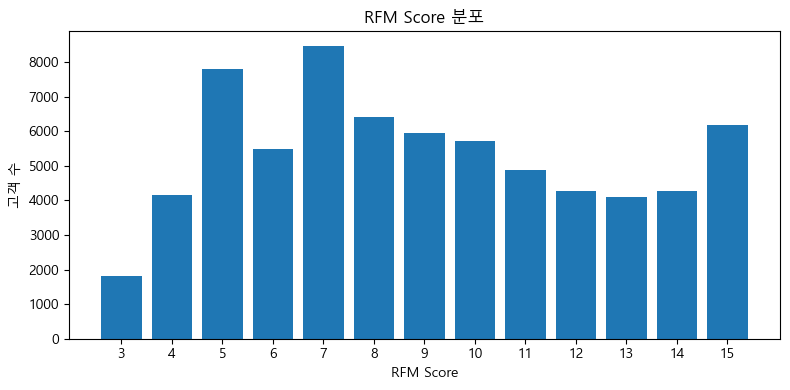

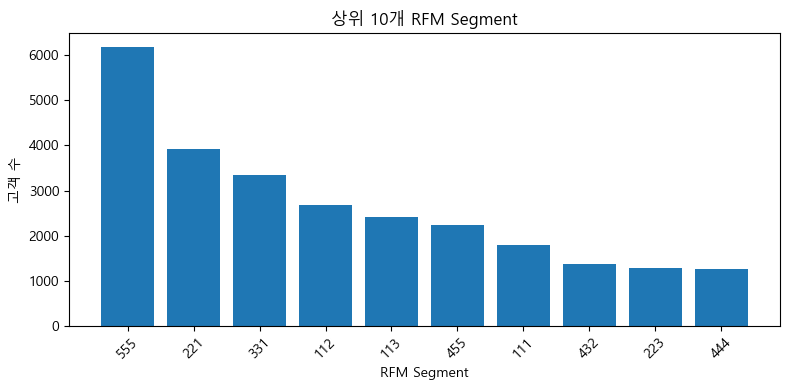

In [8]:
# RFM Score별 고객 수 분포 집계
rfm_score_counts = rfm['RFM_Score'].value_counts().sort_index()

# 상위 10개 RFM Segment 집계
top_segments = rfm['RFM_Segment'].value_counts().head(10)

# 시각화 시작
import matplotlib.pyplot as plt
import matplotlib as mpl

# 한글 폰트 설정 (Windows 기준)
mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

# RFM Score 분포 시각화
plt.figure(figsize=(8,4))
plt.bar(rfm_score_counts.index.astype(str), rfm_score_counts.values)
plt.xlabel('RFM Score')
plt.ylabel('고객 수')
plt.title('RFM Score 분포')
plt.tight_layout()
plt.show()

# 상위 10개 RFM Segment 시각화
plt.figure(figsize=(8,4))
plt.bar(top_segments.index, top_segments.values)
plt.xlabel('RFM Segment')
plt.ylabel('고객 수')
plt.title('상위 10개 RFM Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


1. RFM Score 분포 (위쪽 차트)
- 스코어 범위는 3점(최소)에서 15점(최대) 사이입니다.

- 가장 많은 고객이 몰려 있는 구간은 7점(약 8,400명)과 5점(약 7,800명)입니다.

- 스코어가 낮을수록(34점) 재구매 가능성이 낮거나 마지막 구매가 오래된 고객,
- 스코어가 높을수록(1315점) VIP 고객(최근·빈도·지출 모두 상위)임을 의미합니다.

- 전체적으로 중간값(7~9점)에 고객이 집중되어 있어, 아직 완전한 VIP도 아니고 완전히 이탈한 것도 아닌 “잠재 성장 고객”이 많다는 뜻입니다.

2. 상위 10개 RFM Segment (아래쪽 차트)
|  순위 |                   Segment                   | 의미                                 |     고객 수(대략) |
| :-: | :-----------------------------------------: | :--------------------------------- | -----------: |
|  1  |                   **555**                   | 최근 구매·높은 빈도·높은 지출 → **VIP**        |     \~6,200명 |
|  2  |                   **221**                   | 오래된 구매·중간 빈도·낮은 지출 → **휴면 위험**     |     \~3,900명 |
|  3  |                   **331**                   | 중간 Recency·중간 빈도·중간 지출 → **안정 그룹** |     \~3,300명 |
|  4  |                   **112**                   | 매우 최근 구매·낮은 빈도·낮은 지출 → **신규 고객**   |     \~2,700명 |
|  5  |                   **113**                   | 매우 최근 구매·낮은 빈도·중간 지출 → **잠재 VIP**  |     \~2,400명 |
|  …  | **455**, **111**, **432**, **223**, **444** | (각각 충성고객/이탈위험/중간군 등)               | 1,200–2,300명 |
- 555(VIP)가 압도적으로 가장 큰 세그먼트로, 우선 로열티 프로그램·프리미엄 혜택을 제공해 유지 강화

- 221(휴면 위험), 112(신규), 113(잠재 VIP) 등

- 221: 장기간 비구매 고객이지만 빈도는 중간 → 재활성화 캠페인

- 112·113: 첫 구매가 최근 → 2차 구매 전환·업셀링 프로모션

- 331, 455, 444 등 중간·충성 그룹은 업셀링/크로스셀링으로 지출 증대

3. 요약
- 대다수가 중간 스코어(7~9점)에 분포: “성장 잠재력이 큰 중간 고객”

- 최우수 VIP(555)와 휴면 위험(221), 신규(112)·잠재 VIP(113) 등 5~6개 핵심 세그먼트로 묶어

- VIP 유지, 휴면 재활성화, 신규 전환 전략을 병행

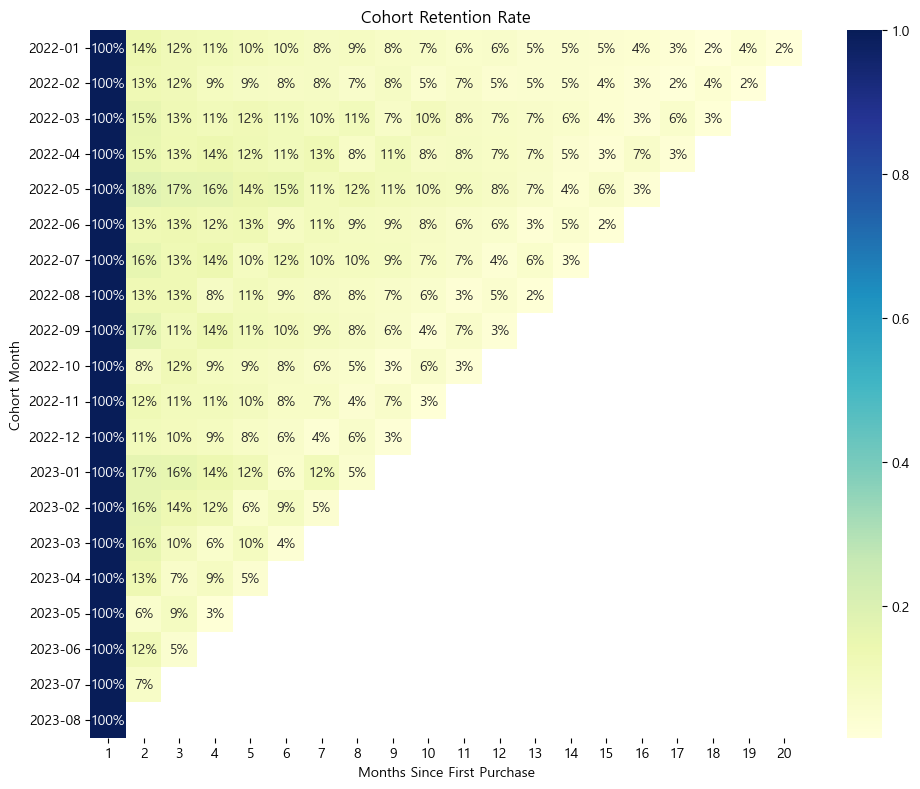

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) 주문월 & CohortMonth 계산
df2['OrderMonth'] = df2['배송완료일'].dt.to_period('M')
first_month = df2.groupby('고객번호')['OrderMonth'].min().rename('CohortMonth')
df2 = df2.join(first_month, on='고객번호')

# 2) CohortIndex (경과 개월) 계산
df2['CohortIndex'] = (df2['OrderMonth'].dt.year - df2['CohortMonth'].dt.year) * 12 + \
                    (df2['OrderMonth'].dt.month - df2['CohortMonth'].dt.month) + 1

# 3) Cohort별 고객 수 집계
cohort_data = df2.groupby(['CohortMonth', 'CohortIndex'])['고객번호'] \
                .nunique().reset_index()

# 4) Pivot & 리텐션율 계산
cohort_pivot = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='고객번호')
retention = cohort_pivot.divide(cohort_pivot.iloc[:, 0], axis=0)

# 5) Heatmap 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(retention, annot=True, fmt=".0%", cmap="YlGnBu")
plt.title("Cohort Retention Rate")
plt.ylabel("Cohort Month")
plt.xlabel("Months Since First Purchase")
plt.tight_layout()
plt.show()


1. 축(Axis) 이해하기
- 세로축(Cohort Month) : 각 행은 ‘고객이 첫 구매를 한 월’을 뜻합니다.
- 예를 들어 맨 위 2022-01 행은 2022년 1월에 첫 구매를 한 고객들의 코호트입니다.

- 가로축(Months Since First Purchase) : 첫 구매 후 몇 개월 차인지를 나타냅니다.
- 1은 구매월(자체)을, 2는 첫 구매 다음 달(1개월 이후), 3는 두 번째 달(2개월 이후)을 의미합니다.

2. 색상(Color) & 숫자(Value) 읽기
- 셀 안의 숫자는 해당 개월 차에 재구매(활동)한 고객 비율(첫 달 대비)입니다.
- 색이 짙을수록(진한 파랑) 비율이 높고, 연할수록(노랑·흰색) 낮습니다.

3. 주요 패턴(Trend) 파악하기
- 초기 급락 구간 (2~3개월 차)
    - 각 코호트에서 ‘첫 구매월(1개월 차)’ 이후 ‘1개월 후(2개월 차)’와 ‘2개월 후(3개월 차)’의 재구매율이 얼마나 떨어졌는지 확인합니다.
    - 대부분 고객이 이 시점에서 이탈(재구매 중단)하므로, 가장 큰 리텐션 리스크 구간입니다.
    - 코호트 A: 1→2개월 차 100%→12% → 3개월 차 8%
    - ⇒ 첫 구매 후 한 달 내 88% 이탈, 두 달 내 92% 이탈
- 안정 유지 구간 (4~6개월 차)
    - 4개월 차부터 6개월 차까지 재구매율이 완만하게 줄어드는지, 혹은 갑작스러운 추가 이탈 지점이 있는지 살핍니다.
    - 이 구간에 머무르는 고객은 충성도가 올라가는 잠재 VIP일 가능성이 높아, 추가 마케팅 투자 가치가 있습니다.
    - 코호트 B: 4개월 차 7% → 5개월 차 6% → 6개월 차 5%
    - ⇒ 비교적 안정적으로 5~7% 사이를 유지
- 장기 이탈 구간 (7~12개월 차)
    - 7개월 차 이후부터 12개월 차까지의 색상 변화로, 장기 생존율을 평가합니다.
    - 장기 고객이 얼마나 남아 있는지 알면 “연간 고객 유지 전략”이 효과적인지 판단할 수 있습니다.
    - 코호트 C: 7개월 차 4% → 12개월 차 2%
    - ⇒ 1년 차 재구매율이 2% 미만으로 떨어짐
- 코호트 간 비교 (월별 편차)
    - 동일 개월 차(예: 3개월 차)에서 서로 다른 코호트 행끼리 색 농도를 비교합니다.
    - 특정 시기에 첫 구매한 고객이 더 오래 머무르는지(색이 진한지) 파악하여 시즌별·프로모션별 효과를 분석할 수 있습니다.
    - 2022-05 코호트의 3개월 차 재구매율 17% vs. 평균 11%
    - ⇒ 5월 프로모션이 다른 달보다 효과적이었을 가능성

4. 인사이트 뽑는 법
- 이탈 방지 타이밍: 급락 구간(2~3개월)에 리마인더·할인쿠폰 발송 계획
- 충성 고객 육성: 4~6개월 차에 머무른 고객을 대상으로 업셀링/크로스셀링
- 1년 주기 캠페인: 12개월 차 이탈 지점에 맞춰 “지난해 구매 감사” 리마인드
- 프로모션 평가: 편차가 큰 코호트(예: 특정 달)에는 마케팅·시즌 효과를 분석

# 같은 주문인데도 배송소요시간 다른 거

In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185350 entries, 0 to 185349
Data columns (total 47 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   주문번호          185350 non-null  object        
 1   배송완료일         185350 non-null  datetime64[ns]
 2   배송시작일         185350 non-null  datetime64[ns]
 3   구매일           185350 non-null  datetime64[ns]
 4   구매시월령         185350 non-null  float64       
 5   고객번호          185350 non-null  object        
 6   구매금액          185350 non-null  float64       
 7   결제금액          185350 non-null  float64       
 8   물품대분류         185350 non-null  category      
 9   성별            185350 non-null  category      
 10  결혼유무          185350 non-null  category      
 11  거주지역          185350 non-null  category      
 12  연령            185350 non-null  float64       
 13  결제등록카드        185350 non-null  category      
 14  유입경로          185350 non-null  category      
 15  자녀여부          185

In [11]:
# 1. 필요한 열만 선택
subset = df2[['고객번호', '구매일', '배송완료일', '거주지역']].copy()

# 2. 고객번호 + 구매일 기준으로 배송완료일 개수 세기
delivery_count = subset.groupby(['고객번호', '구매일'])['배송완료일'].nunique().reset_index(name='배송완료일_고유개수')

# 3. 배송완료일이 2개 이상인 경우 필터링
multiple_deliveries = delivery_count[delivery_count['배송완료일_고유개수'] > 1]

# 4. 원래 df2에서 해당 행 추출
result = df2.merge(multiple_deliveries[['고객번호', '구매일']], on=['고객번호', '구매일'], how='inner')

# 5. 중복 제거 및 정렬
result_filtered = result[['고객번호', '구매일', '배송완료일', '거주지역']].drop_duplicates().sort_values(['고객번호', '구매일'])


In [12]:
같은고객_다른배송일 = result[['고객번호', '구매일', '배송완료일', '거주지역']].drop_duplicates().sort_values(['고객번호', '구매일'])
같은고객_다른배송일

,고객번호,구매일,배송완료일,거주지역
13324,201812310749784,2023-01-17,2023-01-21,충청도
13325,201812310749784,2023-01-17,2023-01-20,충청도
1577,201812310749816,2022-02-27,2022-03-04,인천
1578,201812310749816,2022-02-27,2022-03-02,인천
4517,201812310749839,2022-05-27,2022-05-31,부산
...,...,...,...,...
17882,201912281057997,2023-07-08,2023-07-13,서울
14528,201912291058045,2023-02-22,2023-02-25,경상도
14529,201912291058045,2023-02-22,2023-02-26,경상도
15067,201912291058096,2023-03-07,2023-03-10,서울


In [13]:
len(같은고객_다른배송일) / len(df2) * 100

8.65389803075263

In [14]:
# 지역별 건수
region_counts = 같은고객_다른배송일['거주지역'].value_counts().reset_index()
region_counts.columns = ['거주지역', '건수']

# 전체 건수
total = region_counts['건수'].sum()

# 비율 추가
region_counts['비율(%)'] = (region_counts['건수'] / total * 100).round(2)

# 결과 출력
region_counts


,거주지역,건수,비율(%)
0,경기,3086,19.24
1,충청도,2937,18.31
2,서울,2662,16.60
3,강원,1376,8.58
4,경상도,1359,8.47
5,부산,1347,8.40
6,전라도,892,5.56
7,인천,744,4.64
8,대전,588,3.67
9,대구,442,2.76


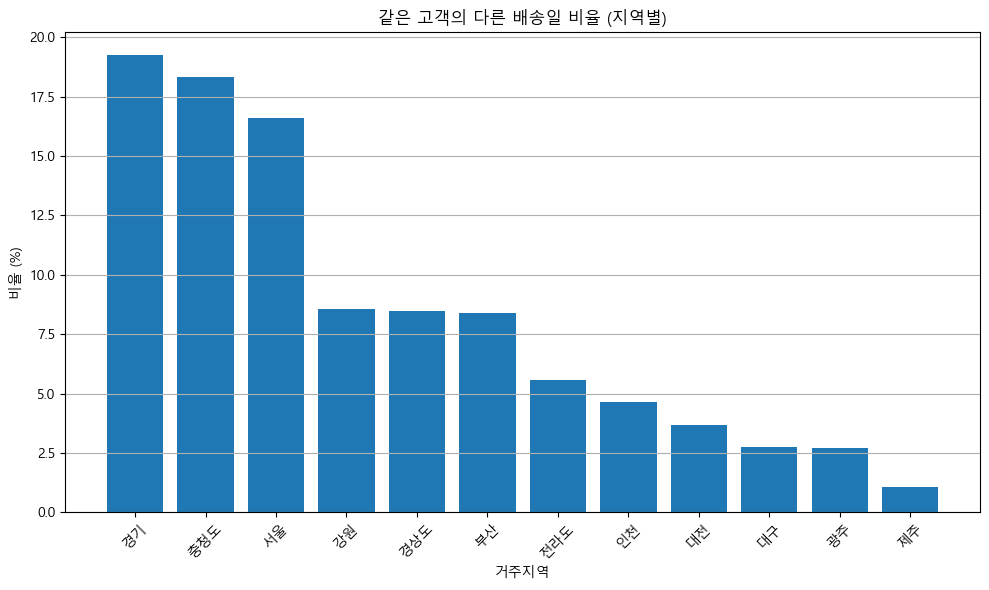

In [15]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# ✅ 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우 기본 한글폰트
else:
    plt.rcParams['font.family'] = 'AppleGothic'  # macOS
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

plt.figure(figsize=(10, 6))
plt.bar(region_counts['거주지역'], region_counts['비율(%)'])
plt.title('같은 고객의 다른 배송일 비율 (지역별)')
plt.xlabel('거주지역')
plt.ylabel('비율 (%)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [16]:
# 1. 같은 고객 + 같은 날 구매한 그룹 중 배송완료일이 2개 이상인 경우만
subset = df2[['고객번호', '구매일', '배송완료일']].copy()

# 2. 배송완료일 차이 계산 (그룹별 최대 - 최소)
delivery_gap = subset.groupby(['고객번호', '구매일'])['배송완료일'].agg(['min', 'max']).reset_index()
delivery_gap['배송일_차이_일'] = (delivery_gap['max'] - delivery_gap['min']).dt.days

# 3. 배송일 차이가 있는 경우만 필터링 (즉, 차이가 1일 이상인 경우)
delivery_gap_filtered = delivery_gap[delivery_gap['배송일_차이_일'] > 0]

# 결과 확인
delivery_gap_filtered.sort_values('배송일_차이_일', ascending=False).head()


,고객번호,구매일,min,max,배송일_차이_일
148628,201911271036863,2023-07-07,2023-07-10,2023-07-14,4
15357,201901230772030,2022-01-23,2022-01-26,2022-01-30,4
39869,201902250813983,2022-02-26,2022-03-01,2022-03-05,4
100645,201906280928657,2022-09-01,2022-09-04,2022-09-08,4
135926,201910101003550,2023-07-12,2023-07-15,2023-07-19,4


In [17]:
# 배송일 차이별 건수 집계
gap_counts = delivery_gap_filtered['배송일_차이_일'].value_counts().sort_index().reset_index()
gap_counts.columns = ['배송일_차이_일', '건수']

# 출력
print(gap_counts)


   배송일_차이_일    건수
0         1  4646
1         2  2971
2         3   177
3         4    34


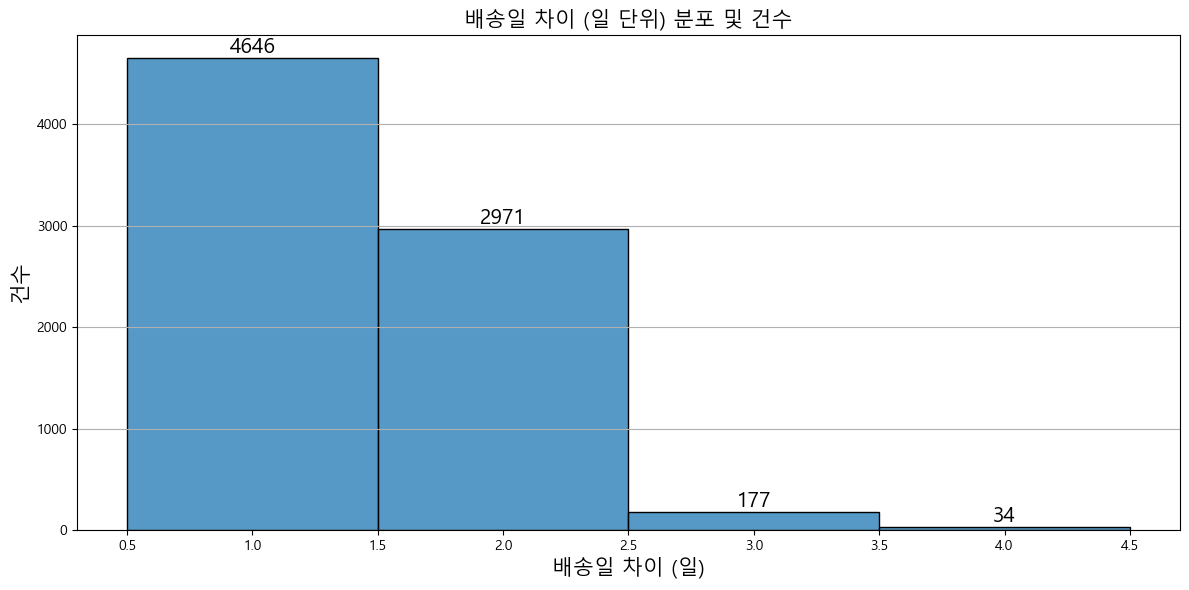

In [18]:
import seaborn as sns
plt.figure(figsize=(12, 6))
ax = sns.histplot(delivery_gap_filtered['배송일_차이_일'], bins=range(1, delivery_gap_filtered['배송일_차이_일'].max() + 2), discrete=True)

# 막대 위에 건수 표시
for p in ax.patches:
    height = int(p.get_height())
    if height > 0:
        ax.annotate(f'{height}', 
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=15)

plt.title('배송일 차이 (일 단위) 분포 및 건수', fontsize=15)
plt.xlabel('배송일 차이 (일)', fontsize=15)
plt.ylabel('건수', fontsize=15)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
